<a href="https://colab.research.google.com/github/sjsu-cs133-f25/team5-climatechange-trends/blob/main/notebooks/05_predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate Change Dataset - Predictive Model and Visual Explanation

### Goals
- Build a simple machine learning model to predict CO2 per capita emissions
- Discover which features influence CO2 per capita emissions the most

# Data Card


Dataset source & link, shape (rows/cols), units, time coverage:
*   Dataset source: Global Warming Dataset: 195 Countries (1900-2023)
*   Dataset link: https://www.kaggle.com/datasets/ankushpanday1/global-warming-dataset-195-countries-1900-2023
*   shape: 100,000 rows and 26 columns
*   units: numerical, categorical
*   time coverage: 1900-2023


Column dictionary (human-readable; short), key ID columns, target(s) if any:
*   shape: 100,000 rows and 26 columns

      * Country - the country identifier
      * Year - the year, from 1900-2023
      * Temperature_Anomoly - difference in temperature from baseline, in °C
      * CO2_Emissions - total CO2 emissions, in metric tons
      * Population - number of people in the country
      * Forest Area - area of forest cover, in % of land area
      * GDP - Gross Domestic Product, in USD
      * Renewable_Energy_Usage - total energy derived from renewable energy sources, in %
      * Methane_Emissions - total methane emissions, in metric tons CO2 equivalent
      * Sea_Level_Rise - change in sea level, in mm
      * Arctic_Ice_Extent - area covered by arctic ice, in million km²
      * Urbanization - population living in urban areas, in %
      * Deforestation_Rate - loss of forest area, in %
      * Extreme_Weather_Events - count of extreme events that occurred
      * Average_Rainfall - average precipitation, in mm
      * Solar_Energy_Potential - potential for solar energy, in kWh/m²
      * Waste_Management - score of the country's waste management practices, in %
      * Per_Capita_Emissions - total greenhouse gases emissions per capita, in tons / person
      * Industrial_Activity - industrial output or production, in %
      * Air_Pollution_Index - air quality index, from 0-300
      * Biodiversity_Index - measures the variety of species, in %
      * Ocean_Acidification - pH level of ocean
      * Fossil_Fuel_Usage - total energy consumption from fossil fuels, in %
      * Energy_Consumption_Per_Capita - energy usage per person
      * Policy_Score - the country's climate policy performance score, from 0-100
      * Average_Temperature - average temperature, in °C



Missingness snapshot: which columns have NaNs and rough %:
*   NaNs: 14 missing values found


Known quirks (e.g., mixed types, inconsistent labels):
*    the meaning of the values for some of the columns, such as the policy score, and the units for some are ambiguous
*    The countries column did not specify the names of the actual countries and instead labeled countries numerically


## Data Load and Prep

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import kagglehub
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
# download dataset
path = kagglehub.dataset_download("ankushpanday1/global-warming-dataset-195-countries-1900-2023")

# read csv file
global_warming_data = pd.read_csv(path + "/global_warming_dataset.csv")

100%|██████████| 20.5M/20.5M [00:01<00:00, 20.7MB/s]

Extracting files...


In [3]:
# 1 Remove spaces
global_warming_data = global_warming_data.rename(columns=lambda c: c.strip().replace(" ", "_"))

# 2 Convert to numeric
global_warming_data["Year"] = pd.to_numeric(global_warming_data["Year"], errors="coerce").astype("Int64")
global_warming_data["Country"] = global_warming_data["Country"].astype("category")

num_cols = global_warming_data.columns.difference(["Country", "Year"])
global_warming_data[num_cols] = global_warming_data[num_cols].apply(pd.to_numeric, errors="coerce")

# 3 Handle missing values
global_warming_data[num_cols] = global_warming_data[num_cols].fillna(global_warming_data[num_cols].median())

# 4 Group by Country, Year
global_warming_data = global_warming_data.groupby(["Country", "Year"], as_index=False, observed=False).mean(numeric_only=True)

print("Missing Values:", global_warming_data.isna().any().sum())
print("Duplicates:", global_warming_data.duplicated().sum())

Missing Values: 24
Duplicates: 0


# Exploratory Data Analysis (EDA)

### Transforms

In [ ]:
# Make copy for EDA
df = global_warming_data.copy()

# Make categories ordered for nicer sorting/plots.
gdp_order = pd.CategoricalDtype(
    categories=["Low Income", "Lower-Middle Income", "Upper-Middle Income", "High Income"],
    ordered=True
)

cat_order = pd.CategoricalDtype(
    categories=["Low", "Medium", "High"],
    ordered=True
)

# Temperature increase flag
df["Temp_Increased"] = df["Temperature_Anomaly"] > 0

# Air Quality Category
def pollution_category(x):
    if x > 200:     return "Very Unhealthy"
    elif x > 150:   return "Unhealthy"
    elif x > 100:   return "Unhealthy (Sensitive)"
    elif x > 50:    return "Moderate"
    else:           return "Good"
df["Air_Quality_Category"] = df["Air_Pollution_Index"].map(pollution_category)

# GDP per capita and Income group
df["GDP_per_capita"] = df["GDP"] / df["Population"]

def gdp_category(x):
    if x >= 13846:  return "High Income"
    elif x >= 4466: return "Upper-Middle Income"
    elif x >= 1136: return "Lower-Middle Income"
    else:           return "Low Income"
df["GDP_Income_Group"] = df["GDP_per_capita"].map(gdp_category).astype(gdp_order)

# CO2 per capita
df["CO2_per_capita"] = df["CO2_Emissions"] / df["Population"]

# Renewable Energy Usage Groups
def renewable_group(x):
    if x >= 50:     return "High"
    elif x >= 20:   return "Medium"
    else:           return "Low"
df["Renewable_Group"] = df["Renewable_Energy_Usage"].apply(renewable_group).astype("category")

# Industrial Activity Groups
def industrial_activity_group(x):
    if x >= 80:     return "High"
    elif x < 80 & x >= 40:   return "Medium"
    else:           return "Low"
df['Industrial_Activity_Group'] = df.Industrial_Activity.map(renewable_group).astype(cat_order)

# Decades
def get_decade(year):
  decade = year // 10
  decade_str = str(decade * 10) + "'s"
  return decade_str

df['Decade'] = df.Year.map(get_decade)

# Log versions for heavy-tailed per-capita vars (for clearer structure)
df["log_CO2_per_capita"] = np.log1p(df["CO2_per_capita"])
df["log_GDP_per_capita"] = np.log1p(df["GDP_per_capita"])

df

,Country,Year,Temperature_Anomaly,CO2_Emissions,Population,Forest_Area,GDP,Renewable_Energy_Usage,Methane_Emissions,Sea_Level_Rise,...,Temp_Increased,Air_Quality_Category,GDP_per_capita,GDP_Income_Group,CO2_per_capita,Renewable_Group,Industrial_Activity_Group,Decade,log_CO2_per_capita,log_GDP_per_capita
0,Country_1,1900,-0.335027,3.984644e+08,3.750466e+08,27.856810,4.573252e+12,60.185651,5.169077e+06,24.478590,...,False,Unhealthy,12193.823826,Upper-Middle Income,1.062440,High,High,1900's,0.723890,9.408767
1,Country_1,1901,0.170373,8.440511e+08,1.001558e+09,69.848395,4.868018e+12,39.525191,2.619170e+06,11.040926,...,True,Unhealthy (Sensitive),4860.447686,Upper-Middle Income,0.842738,Medium,Medium,1900's,0.611253,8.489092
2,Country_1,1902,0.448391,7.090039e+08,3.604418e+08,50.116560,5.464041e+12,71.867926,6.380284e+06,27.972579,...,True,Unhealthy,15159.287549,High Income,1.967041,High,High,1900's,1.087565,9.626435
3,Country_1,1903,1.254878,7.388654e+08,9.164562e+08,68.083451,4.415206e+12,45.673511,5.175568e+06,13.719263,...,True,Unhealthy,4817.695221,Upper-Middle Income,0.806220,Medium,Medium,1900's,0.591236,8.480258
4,Country_1,1904,0.455433,5.804757e+08,4.870284e+08,21.907529,5.453627e+12,55.241938,3.343214e+06,11.041168,...,True,Unhealthy (Sensitive),11197.759534,Upper-Middle Income,1.191872,High,High,1900's,0.784756,9.323558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24175,Country_99,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,Good,NaN,Low Income,NaN,Low,Low,2010's,NaN,NaN
24176,Country_99,2020,1.109231,2.160874e+08,5.049405e+08,45.809165,9.250810e+12,0.301486,4.548326e+06,3.454109,...,True,Good,18320.594451,High Income,0.427946,Low,Low,2020's,0.356237,9.815836
24177,Country_99,2021,-0.299082,4.082414e+08,7.817556e+08,46.226872,5.454563e+12,36.308012,7.981679e+06,29.121755,...,False,Unhealthy (Sensitive),6977.324415,Upper-Middle Income,0.522211,Medium,High,2020's,0.420164,8.850564
24178,Country_99,2022,0.123644,5.541478e+08,4.541218e+08,69.822316,3.806007e+12,41.631804,2.784789e+06,27.854428,...,True,Unhealthy,8381.027328,Upper-Middle Income,1.220263,Medium,High,2020's,0.797625,9.033845


### Barplots

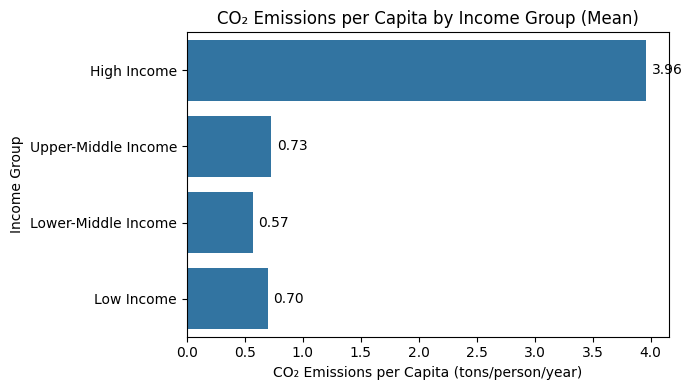

In [ ]:
# Plot showing CO₂ per capita by income group
co2pc_by_income = (
    df.groupby("GDP_Income_Group", observed=False)["CO2_per_capita"]
      .agg(mean="mean", median="median")
      .reset_index()
      .sort_values("mean", ascending=False)
)

plt.figure(figsize=(7,4))
plt.title("CO₂ Emissions per Capita by Income Group (Mean)")
plt.xlabel("CO₂ Emissions per Capita (tons/person/year)")
plt.ylabel("Income Group")
plt.ticklabel_format(style="plain", axis="x")
order = ["High Income","Upper-Middle Income","Lower-Middle Income","Low Income"]
ax = sns.barplot(data=co2pc_by_income, y="GDP_Income_Group", x="mean", order=order)


for p in ax.patches:
    ax.annotate(f"{p.get_width():.2f}",
                (p.get_width(), p.get_y()+p.get_height()/2),
                xytext=(4,0), textcoords="offset points", va="center")
plt.tight_layout()

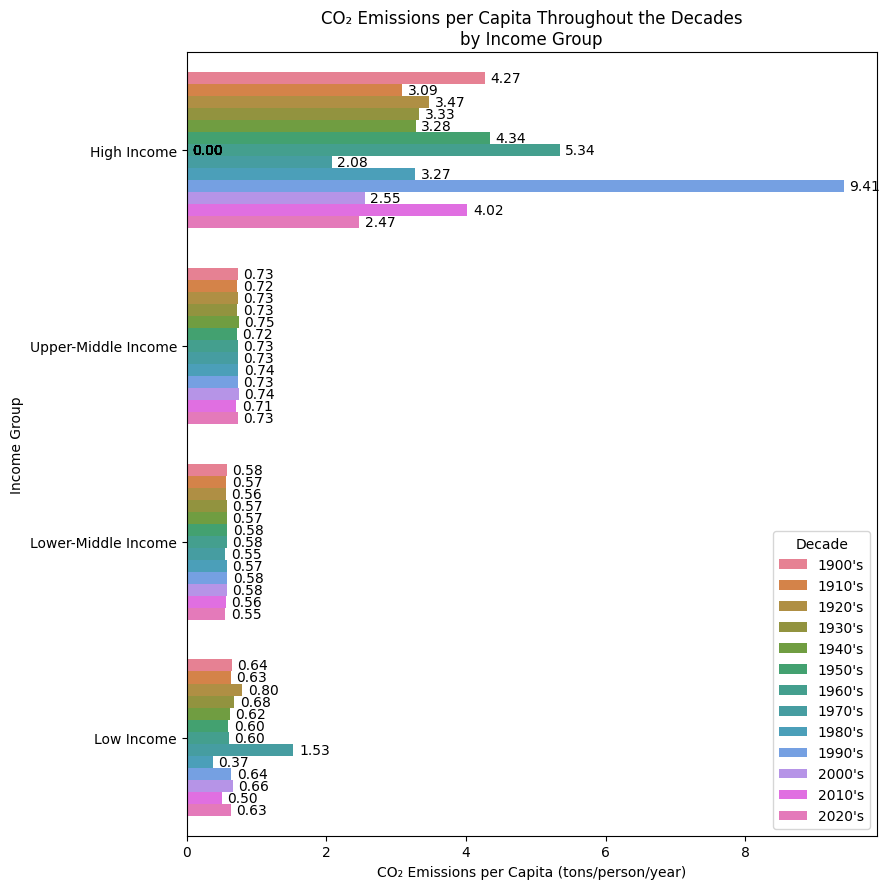

In [ ]:
# Barplot illustrating CO2 Emissions per capita throughout the decades (by income group)
plt.figure(figsize=(9,9))
plt.title("CO₂ Emissions per Capita Throughout the Decades\nby Income Group")
plt.xlabel("CO₂ Emissions per Capita (tons/person/year)")
plt.ylabel("Income Group")
plt.ticklabel_format(style="plain", axis="x")

order = ["High Income","Upper-Middle Income","Lower-Middle Income","Low Income"]
ax = sns.barplot(data=df, y="GDP_Income_Group", x="CO2_per_capita", hue="Decade",
                 errorbar=None, order=order)

for p in ax.patches:
    ax.annotate(f"{p.get_width():.2f}",
                (p.get_width(), p.get_y()+p.get_height()/2),
                xytext=(4,0), textcoords="offset points", va="center")
plt.tight_layout()

### Categorical Distribution Comparison Plots

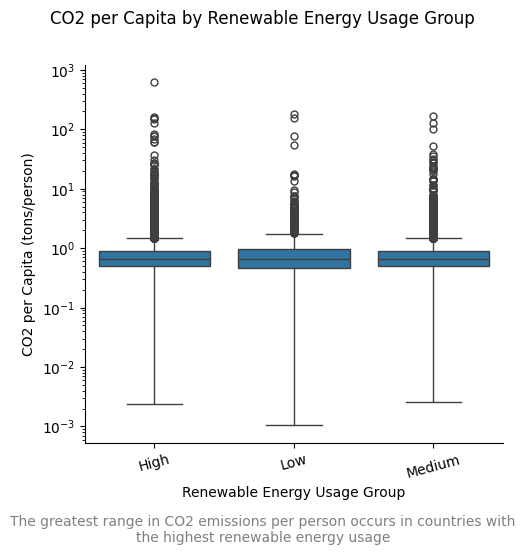

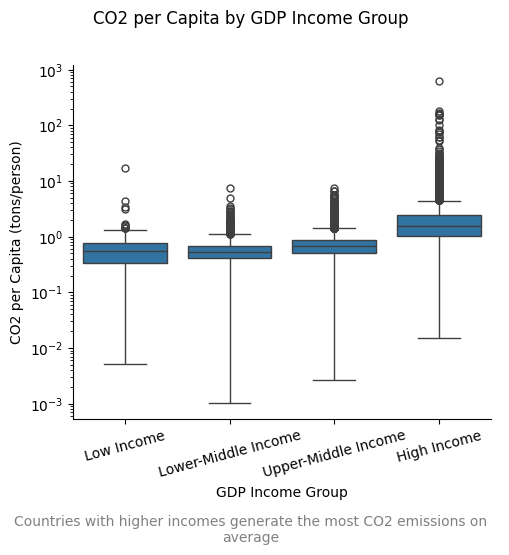

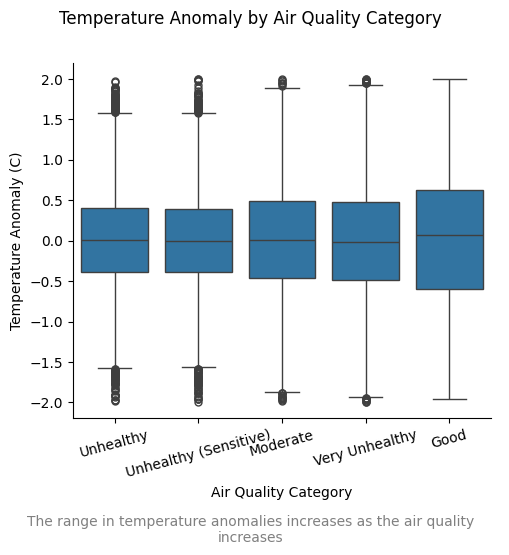

In [ ]:
# CO2 per Capita by Renewable Energy Usage Group
g = sns.catplot(
    data=df,
    x="Renewable_Group",
    y="CO2_per_capita",
    kind="box",
)
g.set(yscale="log")
g.set_axis_labels("Renewable Energy Usage Group", "CO2 per Capita (tons/person)")
g.figure.suptitle("CO2 per Capita by Renewable Energy Usage Group", y=1.01)
plt.xticks(rotation=15)
g.figure.tight_layout()

caption_text = "The greatest range in CO2 emissions per person occurs in countries with the highest renewable energy usage"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')

# CO2 per Capita by GDP Income Group
g = sns.catplot(
    data=df,
    x="GDP_Income_Group",
    y="CO2_per_capita",
    kind="box",
)
g.set(yscale="log")
g.set_axis_labels("GDP Income Group", "CO2 per Capita (tons/person)")
g.figure.suptitle("CO2 per Capita by GDP Income Group", y=1.01)
plt.xticks(rotation=15)
g.figure.tight_layout()

caption_text = "Countries with higher incomes generate the most CO2 emissions on average"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')

# Temperature Anomaly by Air Quality Category
g = sns.catplot(
    data=df,
    x="Air_Quality_Category",
    y="Temperature_Anomaly",
    kind="box",
)
g.set_axis_labels("Air Quality Category", "Temperature Anomaly (C)")
g.figure.suptitle("Temperature Anomaly by Air Quality Category", y=1.01)
plt.xticks(rotation=15)
g.figure.tight_layout();

caption_text = "The range in temperature anomalies increases as the air quality increases"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray');


### Clustered Correlation Block Plot

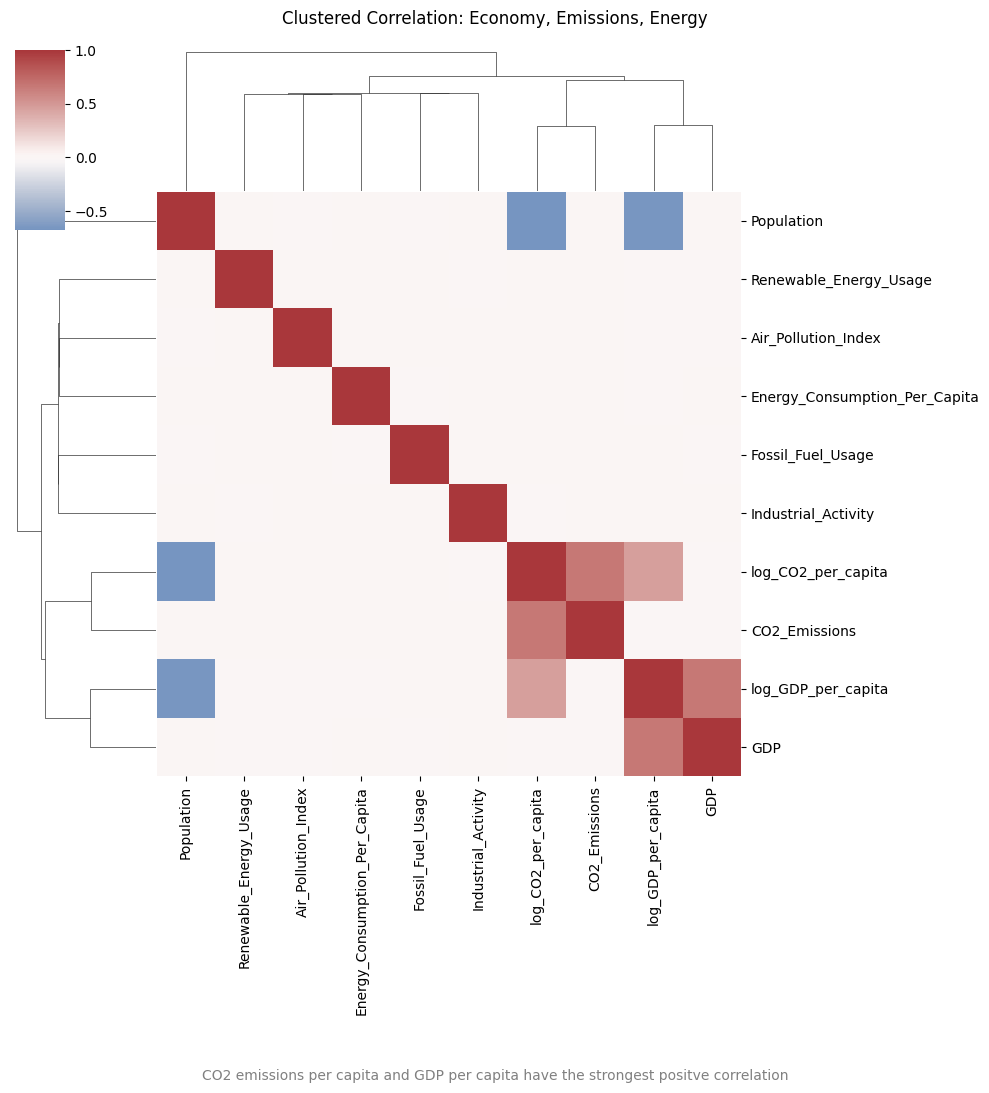

In [ ]:
cols = ["log_CO2_per_capita","log_GDP_per_capita","CO2_Emissions","GDP","Population",
        "Air_Pollution_Index","Renewable_Energy_Usage","Fossil_Fuel_Usage",
        "Energy_Consumption_Per_Capita","Industrial_Activity"]

Z = df[cols].replace([np.inf, -np.inf], np.nan).dropna()
corr = Z.corr("spearman")

# Clustered Correlation
g = sns.clustermap(corr, cmap="vlag", center=0)
g.figure.suptitle("Clustered Correlation: Economy, Emissions, Energy", y=1.02)
caption_text = "CO2 emissions per capita and GDP per capita have the strongest positve correlation"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')
plt.show()

### Pairplot Focus Panel

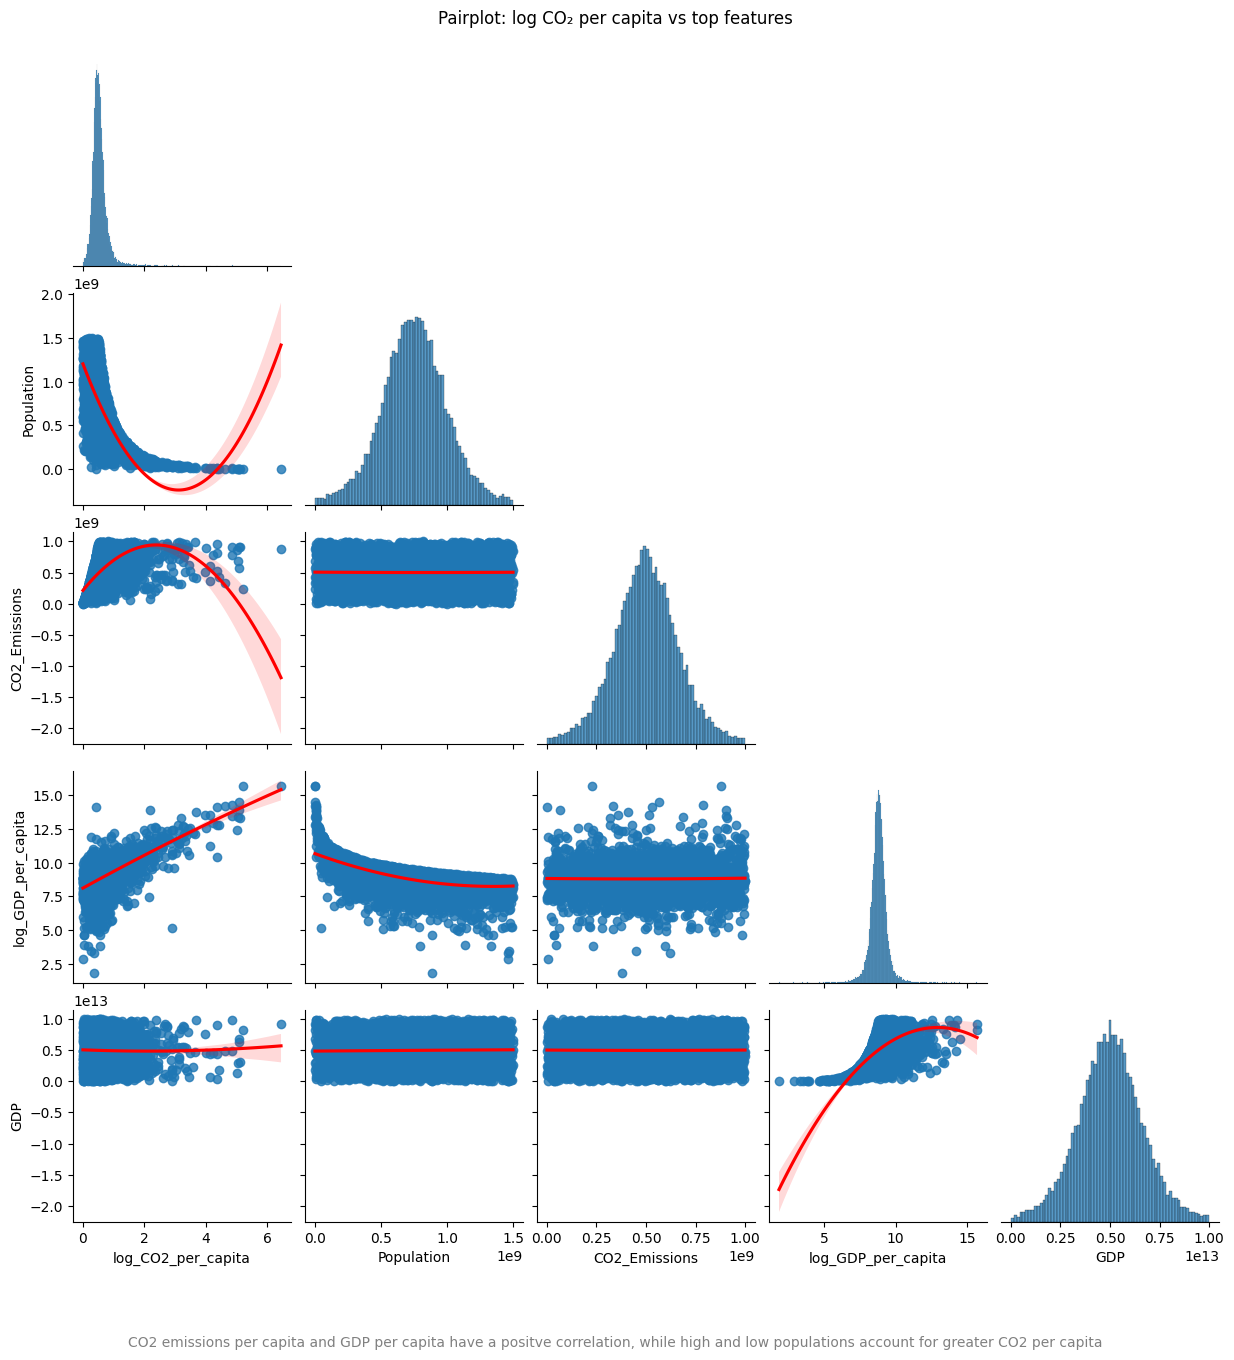

In [ ]:
# Pairplot
top = corr["log_CO2_per_capita"].abs().nlargest(5).index
sns.pairplot(Z[top], kind="reg", corner=True, plot_kws={"order":2, "line_kws":{"color":"red"}})
plt.suptitle("Pairplot: log CO₂ per capita vs top features", y=1.02)
caption_text = "CO2 emissions per capita and GDP per capita have a positve correlation, while high and low populations account for greater CO2 per capita"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')
plt.show()

### Regression Plots

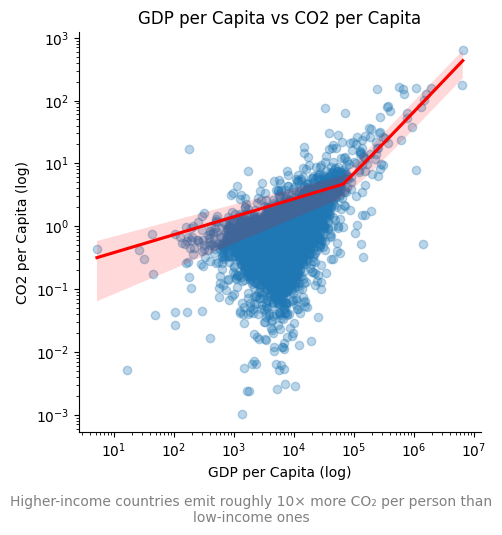

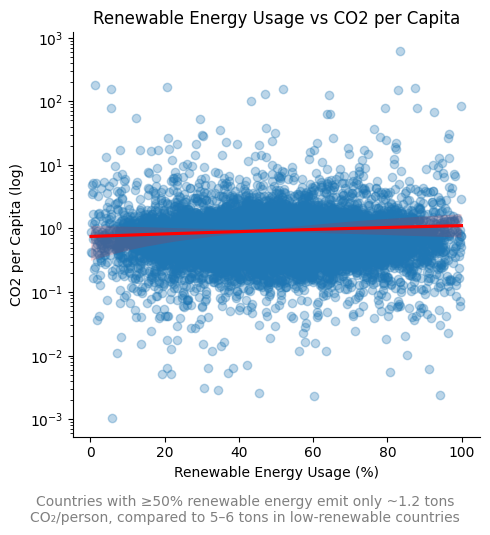

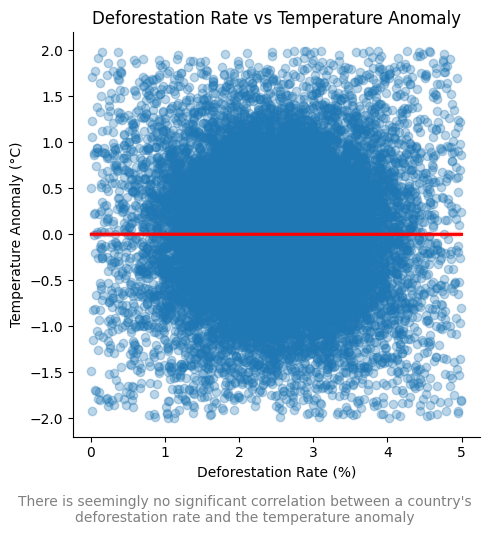

In [ ]:
# GDP per Capita vs CO2 per Capita
sns.lmplot(
    data=df,
    x="GDP_per_capita",
    y="CO2_per_capita",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"},
)
plt.xscale("log")
plt.yscale("log")
plt.title("GDP per Capita vs CO2 per Capita")
plt.xlabel("GDP per Capita (log)")
plt.ylabel("CO2 per Capita (log)")
plt.tight_layout()

caption_text = "Higher-income countries emit roughly 10× more CO₂ per person than low-income ones"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')

# Renewable Energy Usage vs CO2 per Capita
sns.lmplot(
    data=df,
    x="Renewable_Energy_Usage",
    y="CO2_per_capita",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"},
)
plt.yscale("log")
plt.title("Renewable Energy Usage vs CO2 per Capita")
plt.xlabel("Renewable Energy Usage (%)")
plt.ylabel("CO2 per Capita (log)")
plt.tight_layout()

caption_text = "Countries with ≥50% renewable energy emit only ~1.2 tons CO₂/person, compared to 5–6 tons in low-renewable countries"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')

# Deforestation Rate vs Temperature Anomaly
sns.lmplot(
    data=df,
    x="Deforestation_Rate",
    y="Temperature_Anomaly",
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"},
)
plt.title("Deforestation Rate vs Temperature Anomaly")
plt.xlabel("Deforestation Rate (%)")
plt.ylabel("Temperature Anomaly (°C)")
plt.tight_layout();

caption_text = "There is seemingly no significant correlation between a country's deforestation rate and the temperature anomaly"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray');


### Small Multiples Plots

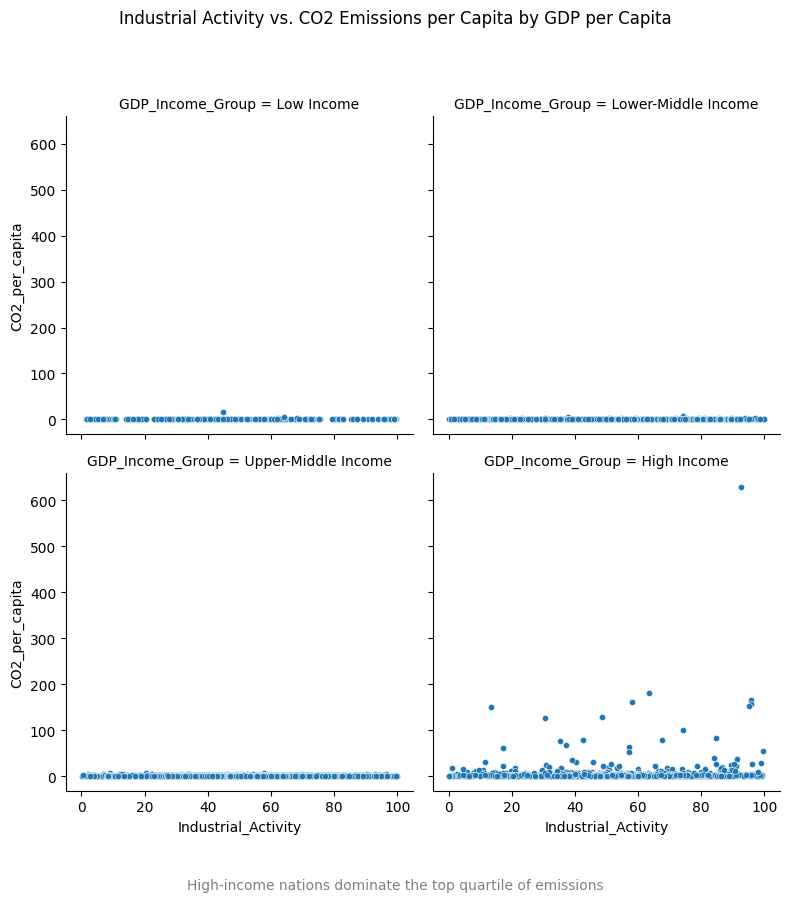

In [ ]:
# Industrial Activity vs. CO2 Emissions per Capita by GDP per Capita
p=sns.relplot(
    data=df,
    x="Industrial_Activity",
    y='CO2_per_capita',
    col="GDP_Income_Group",
    col_wrap=2,
    height=4,
    s=20
)
p.fig.suptitle("Industrial Activity vs. CO2 Emissions per Capita by GDP per Capita", y=1.05);
plt.tight_layout()

caption_text = "High-income nations dominate the top quartile of emissions"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray');

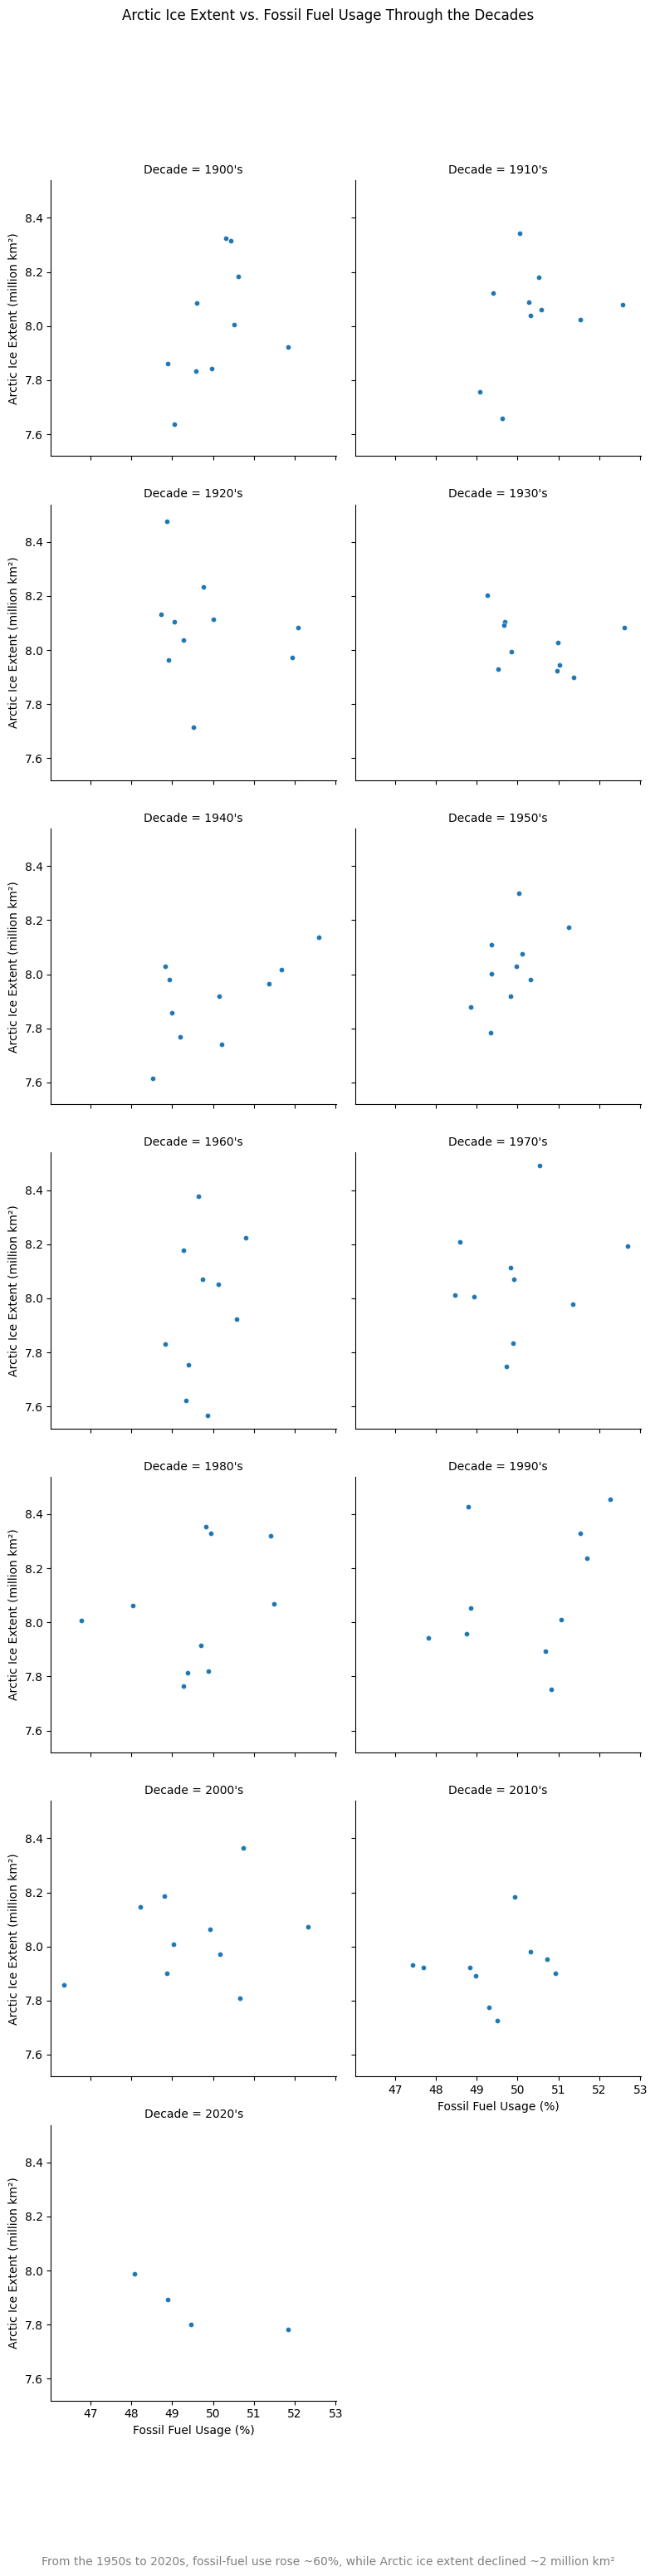

In [ ]:
# Arctic Ice Extent vs. Fossil Fuel Usage Through the Decades
p=sns.relplot(
    data=df,
    x=df.groupby('Year').Fossil_Fuel_Usage.median(),
    y=df.groupby('Year').Arctic_Ice_Extent.median(),
    col="Decade",
    col_wrap=2,
    height=4,
    s=20
)
p.set_ylabels("Arctic Ice Extent (million km²)", clear_inner=False)
p.set_xlabels("Fossil Fuel Usage (%)", clear_inner=False)
p.fig.suptitle("Arctic Ice Extent vs. Fossil Fuel Usage Through the Decades", y=1.05);
plt.tight_layout()
caption_text = "From the 1950s to 2020s, fossil-fuel use rose ~60%, while Arctic ice extent declined ~2 million km²"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray');

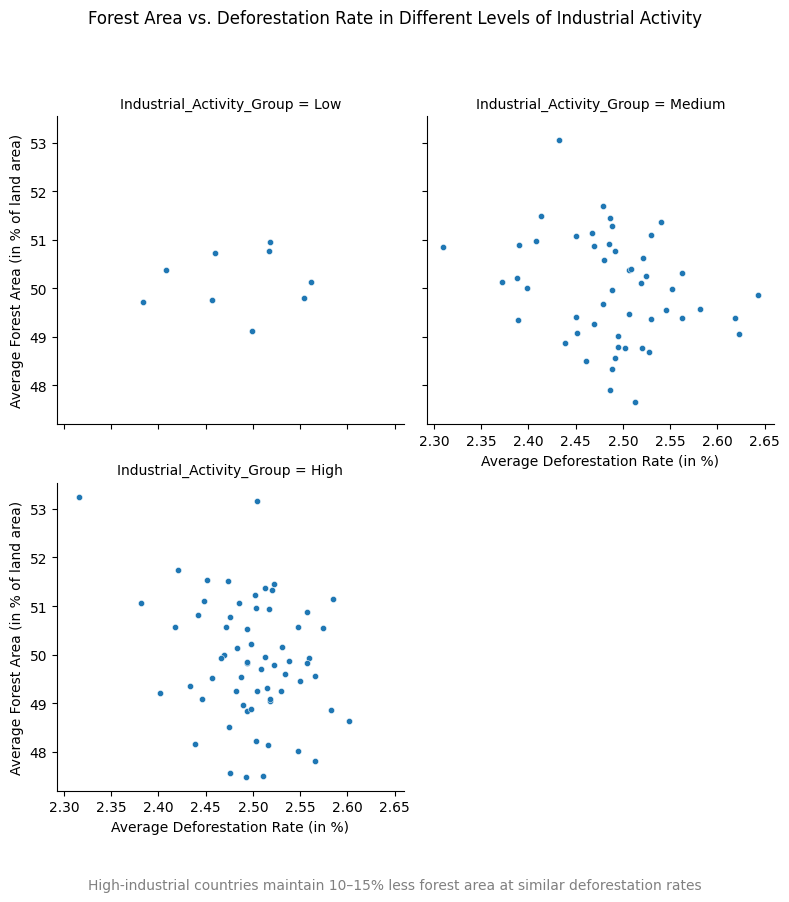

In [ ]:
# Average Forest Area vs. Average Deforestation Rate by Industrial activity
p=sns.relplot(
    data=df,
    x=df.groupby('Year').Deforestation_Rate.mean(),
    y=df.groupby('Year').Forest_Area.mean(),
    col="Industrial_Activity_Group",
    col_wrap=2,
    height=4,
    s=20
)
p.set_ylabels("Average Forest Area (in % of land area)", clear_inner=False)
p.set_xlabels("Average Deforestation Rate (in %)", clear_inner=False)
p.fig.suptitle("Forest Area vs. Deforestation Rate in Different Levels of Industrial Activity", y=1.05);
plt.tight_layout()
caption_text = "High-industrial countries maintain 10–15% less forest area at similar deforestation rates"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray');

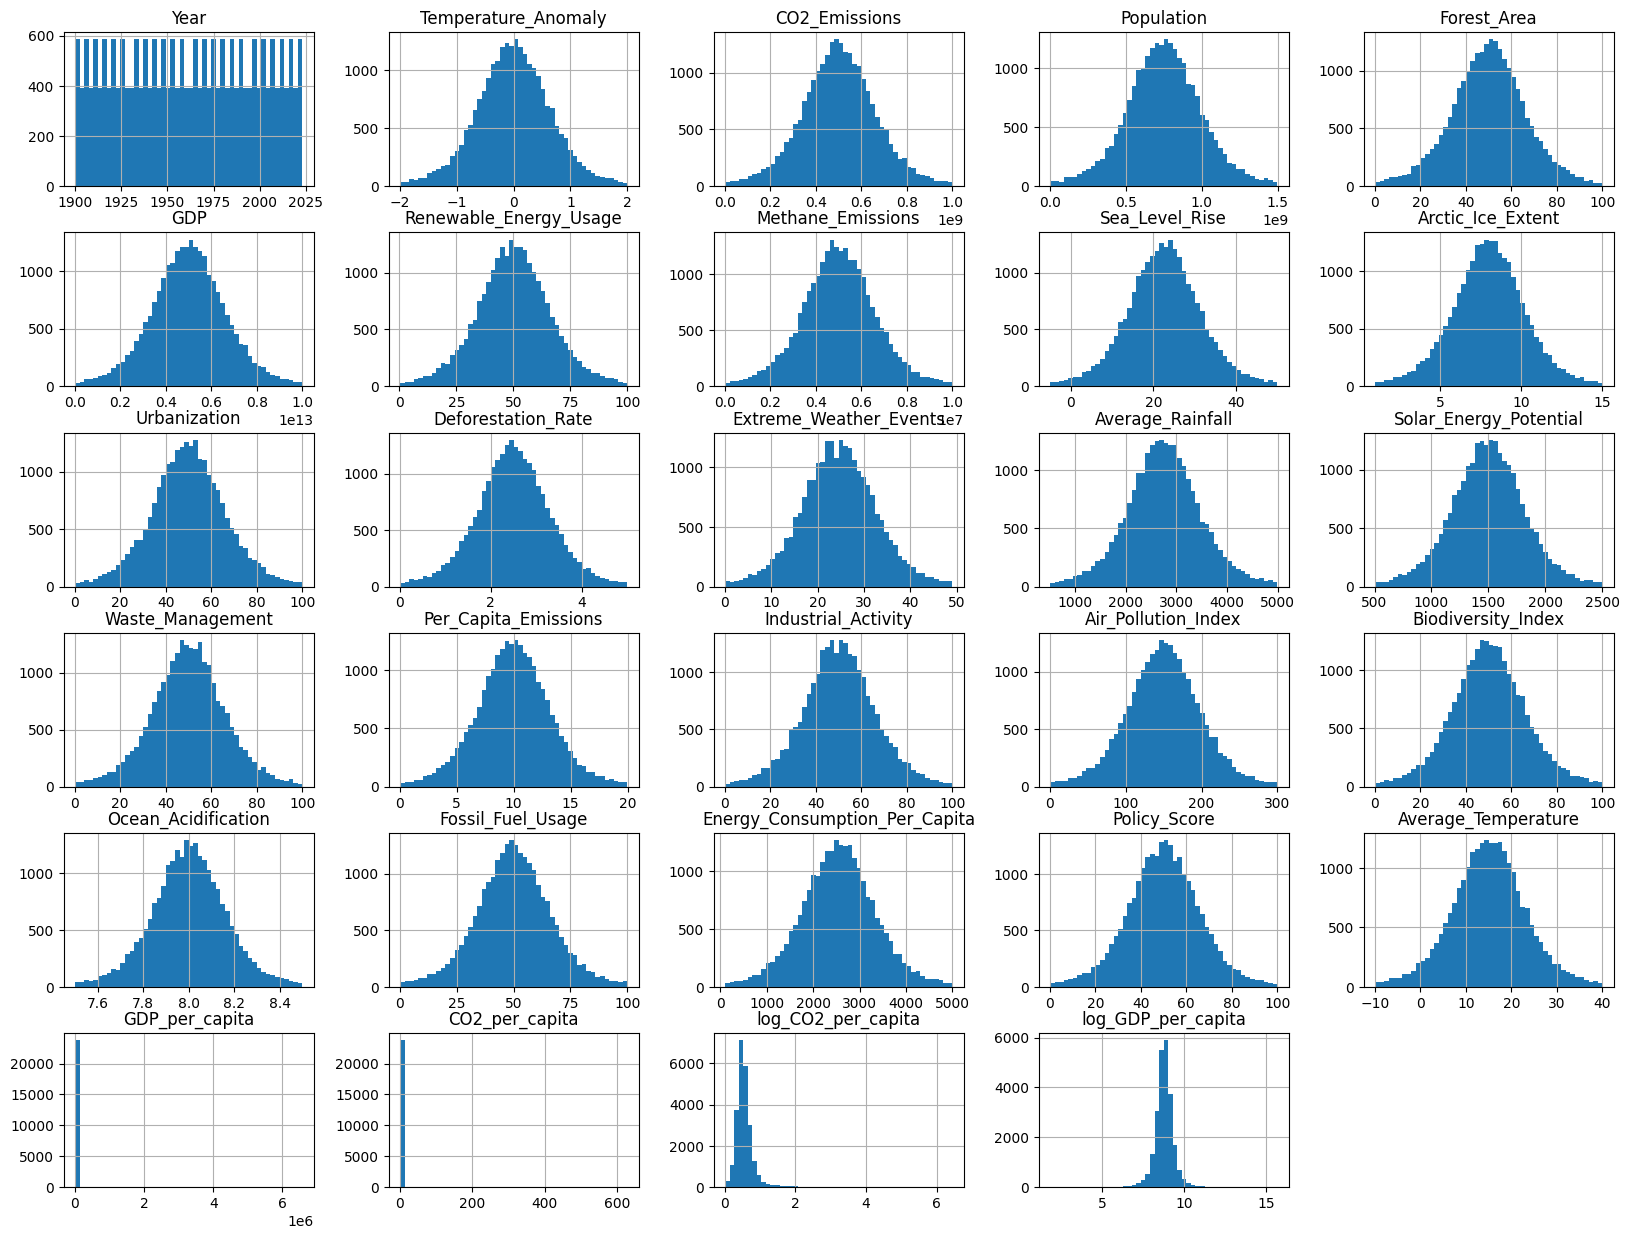

In [ ]:
# Examine distribution of data in each column
df.hist(bins=50, figsize=(20,15))
plt.show()

# Machine Learning Model

### Train Test Split
Since CO2 emissions change throughout time, we need to train our model on older data and then test on newer data.

In [4]:
gdp_order = pd.CategoricalDtype(
    categories=["Low Income", "Lower-Middle Income", "Upper-Middle Income", "High Income"],
    ordered=True
)
def gdp_category(x):
    if x >= 13846:  return "High Income"
    elif x >= 4466: return "Upper-Middle Income"
    elif x >= 1136: return "Lower-Middle Income"
    else:           return "Low Income"

global_warming_data["GDP_per_capita"] = global_warming_data["GDP"] / global_warming_data["Population"]
global_warming_data["CO2_per_capita"] = global_warming_data["CO2_Emissions"] / global_warming_data["Population"]
global_warming_data["Temp_Increased"] = global_warming_data["Temperature_Anomaly"] > 0
global_warming_data["Temp_Increased"] = pd.factorize(global_warming_data['Temp_Increased'], sort=True)[0]

# Split into train and test sets:
# use older data for training, and newer data for test set
train_set = global_warming_data[global_warming_data['Year'] < 2000]
test_set = global_warming_data[global_warming_data['Year'] >= 2000]

In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19500 entries, 0 to 24155
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Country                        19500 non-null  category
 1   Year                           19500 non-null  Int64   
 2   Temperature_Anomaly            19189 non-null  float64 
 3   CO2_Emissions                  19189 non-null  float64 
 4   Population                     19189 non-null  float64 
 5   Forest_Area                    19189 non-null  float64 
 6   GDP                            19189 non-null  float64 
 7   Renewable_Energy_Usage         19189 non-null  float64 
 8   Methane_Emissions              19189 non-null  float64 
 9   Sea_Level_Rise                 19189 non-null  float64 
 10  Arctic_Ice_Extent              19189 non-null  float64 
 11  Urbanization                   19189 non-null  float64 
 12  Deforestation_Rate             19189 

### Data Cleaning

In [6]:
# drop rows w/ missing values
train_set = train_set.dropna()
test_set = test_set.dropna()

# separate X and y
X_train = train_set.drop("CO2_per_capita", axis=1) # drop labels for training set
y_train = train_set["CO2_per_capita"].copy()
X_test = test_set.drop("CO2_per_capita", axis=1)
y_test = test_set["CO2_per_capita"].copy()


# separate out numerical and categorical values
X_train_num = X_train.drop(['Country'], axis=1)
X_test_num = X_test.drop(['Country'], axis=1)
X_train_cat = X_train.loc[:, ['Country']]
X_test_cat = X_test.loc[:, ['Country']]


# Pipeline for numerical attributes
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),  # feature scaling
    ])

# Handle Categorical
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Adding information: handle_unknowns parameter
X_train_cat_1hot = cat_encoder.fit_transform(X_train_cat)

# Pipeline for categorical
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

# Complete the pipeline
num_attribs = list(X_train_num)
cat_attribs = ['Country']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
cols=list(X_train_num.columns) + cat_encoder.categories_[0].tolist()


## Convert the 2D array into Pandas DataFrame
X_train_final = pd.DataFrame(
    X_train_prepared,
    columns=cols,
    index=X_train.index)
X_train_final.head()

,Year,Temperature_Anomaly,CO2_Emissions,Population,Forest_Area,GDP,Renewable_Energy_Usage,Methane_Emissions,Sea_Level_Rise,Arctic_Ice_Extent,...,Country_90,Country_91,Country_92,Country_93,Country_94,Country_95,Country_96,Country_97,Country_98,Country_99
0,-1.715170,-0.514978,-0.633176,-1.541420,-1.337019,-0.252310,0.614706,0.101979,0.212716,0.052865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.680537,0.263680,2.105217,1.019120,1.210576,-0.073363,-0.646155,-1.463122,-1.284325,2.055971,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.645903,0.692017,1.275272,-1.601109,0.013461,0.288470,1.327649,0.845402,0.601968,-0.624742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.611269,1.934553,1.458789,0.671311,1.103498,-0.348257,-0.270937,0.105963,-0.985941,-0.962382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.576636,0.702865,0.485391,-1.083752,-1.697957,0.282148,0.313002,-1.018713,-1.284298,-0.899000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# for test set


# Handle Categorical
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_test_cat_1hot = cat_encoder.fit_transform(X_test_cat)

# use pipeline
X_test_prepared = full_pipeline.transform(X_test)

## Convert the 2D array into Pandas DataFrame
X_test_final = pd.DataFrame(
    X_test_prepared,
    columns=cols,
    index=X_test.index)
X_test_final.head()

,Year,Temperature_Anomaly,CO2_Emissions,Population,Forest_Area,GDP,Renewable_Energy_Usage,Methane_Emissions,Sea_Level_Rise,Arctic_Ice_Extent,...,Country_90,Country_91,Country_92,Country_93,Country_94,Country_95,Country_96,Country_97,Country_98,Country_99
100,1.748196,-0.832956,-0.880902,1.231098,0.622823,-0.350333,0.432636,0.062198,-0.009546,0.564392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,1.782829,1.621777,1.190621,0.493604,-1.381809,1.413752,-0.338745,-0.184425,-1.240573,1.557874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,1.817463,-0.708017,0.145644,-0.057371,0.098752,0.076377,0.829067,0.239280,0.876298,-0.303107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,1.852097,0.545212,-1.082868,1.706244,-1.922361,0.155970,0.428368,-0.155185,0.493032,2.093886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,1.886730,-1.358174,-0.329855,-0.115308,-0.147952,-0.859727,-1.204834,-0.391258,0.070645,0.030678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train Model

In [8]:
# Linear Regression model
lin_reg = LinearRegression()

# Determine best parameters
param_grid = {'copy_X': [True, False], 'fit_intercept': [True, False],
              'n_jobs': [10, 15, 20, None], 'positive': [True, False]}

# train across 5 folds
grid_search = GridSearchCV(lin_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [10, 15, 20, None],
                         'positive': [True, False]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [9]:
# see results of training
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

print(f"\nBest estimator: {grid_search.best_estimator_}")
print(f"Best parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
print(f"r2_score: {r2_score(y_pred = best_model.predict(X_test_final), y_true = y_test)}")

4.86665850305838 {'copy_X': True, 'fit_intercept': True, 'n_jobs': 10, 'positive': True}
4.785768481327134 {'copy_X': True, 'fit_intercept': True, 'n_jobs': 10, 'positive': False}
4.86665850305838 {'copy_X': True, 'fit_intercept': True, 'n_jobs': 15, 'positive': True}
4.785768481327134 {'copy_X': True, 'fit_intercept': True, 'n_jobs': 15, 'positive': False}
4.86665850305838 {'copy_X': True, 'fit_intercept': True, 'n_jobs': 20, 'positive': True}
4.785768481327134 {'copy_X': True, 'fit_intercept': True, 'n_jobs': 20, 'positive': False}
4.86665850305838 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': True}
4.785768481327134 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
4.8683056482193665 {'copy_X': True, 'fit_intercept': False, 'n_jobs': 10, 'positive': True}
4.874960509883724 {'copy_X': True, 'fit_intercept': False, 'n_jobs': 10, 'positive': False}
4.8683056482193665 {'copy_X': True, 'fit_intercept': False, 'n_jobs': 15, 'positive': True}


In [10]:
# Train on full train set with best parameters
best_model.fit(X_train_final, y_train)

# Test final model with test set
final_predictions = best_model.predict(X_test_final)


# final results
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, final_predictions)
r2 = r2_score(y_test, final_predictions)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final MSE: {mse}")
print(f"Final RMSE: {rmse}")
print(f"Final MAE: {mae}")
print(f"Final R²: {r2:.4f}")

Best Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 10, 'positive': False}
Final MSE: 3.689622280207882
Final RMSE: 1.9208389521789384
Final MAE: 0.3853328465673511
Final R²: 0.5517


# Visuals

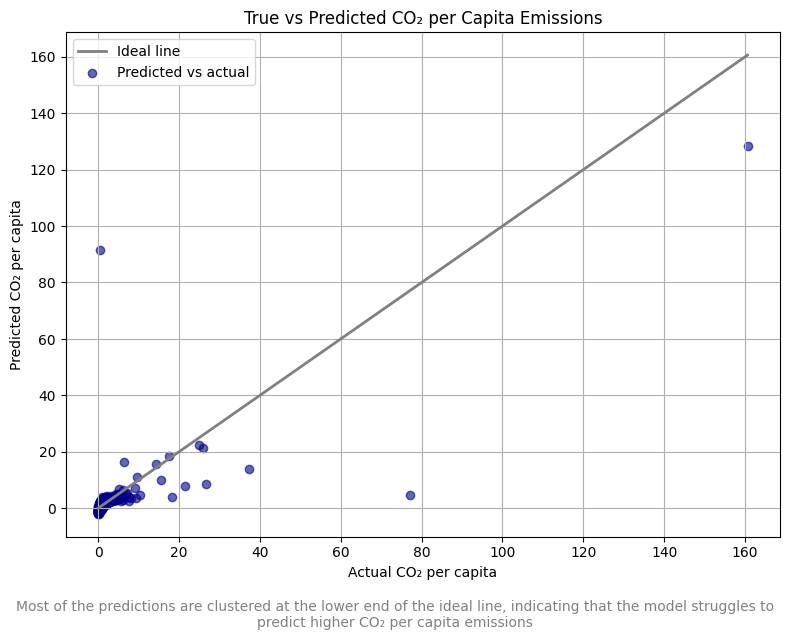

In [16]:
# Actual vs. Predicted CO₂ per Capita
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='grey',
    lw=2,
    label='Ideal line'
)
ax.scatter(y_test, final_predictions, color='darkblue', alpha=0.6, label='Predicted vs actual')

ax.set_xlabel('Actual CO₂ per capita')
ax.set_ylabel('Predicted CO₂ per capita')
ax.set_title('True vs Predicted CO₂ per Capita Emissions')
ax.legend()
ax.grid(True)
fig.tight_layout()

fig.savefig("fig_actual_vs_predicted_co2.png", dpi=300, bbox_inches="tight")

caption_text = "Most of the predictions are clustered at the lower end of the ideal line, indicating that the model struggles to predict higher CO₂ per capita emissions"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')

plt.show();


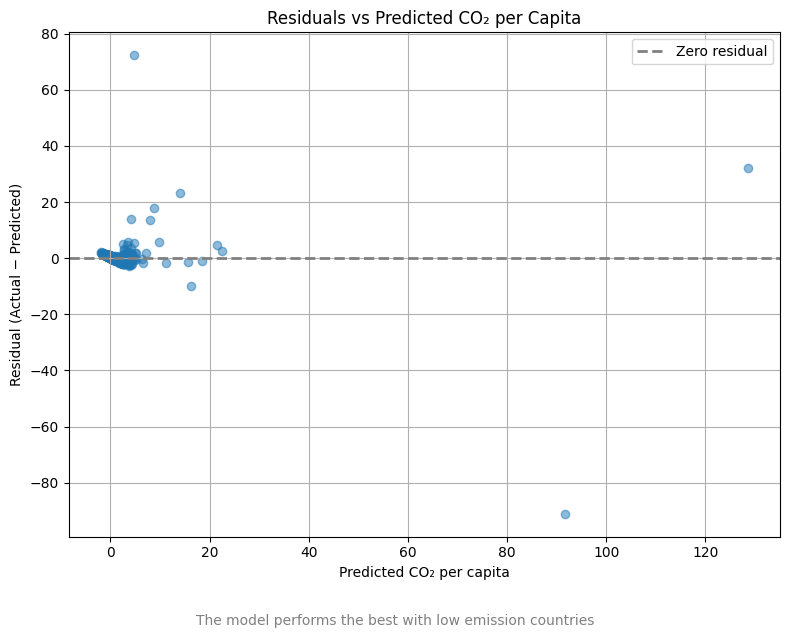

In [17]:
# Residuals vs Predicted CO₂ per Capita
residuals = y_test - final_predictions

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(0, color="grey", linestyle="--", linewidth=2, label="Zero residual")
ax.scatter(final_predictions, residuals, alpha=0.5)

ax.set_xlabel("Predicted CO₂ per capita")
ax.set_ylabel("Residual (Actual − Predicted)")
ax.set_title("Residuals vs Predicted CO₂ per Capita")
ax.grid(True)
ax.legend()
fig.tight_layout()

fig.savefig("fig_residuals_vs_predicted_co2.png", dpi=300, bbox_inches="tight")

caption_text = "The model performs the best with low emission countries"
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')

plt.show()



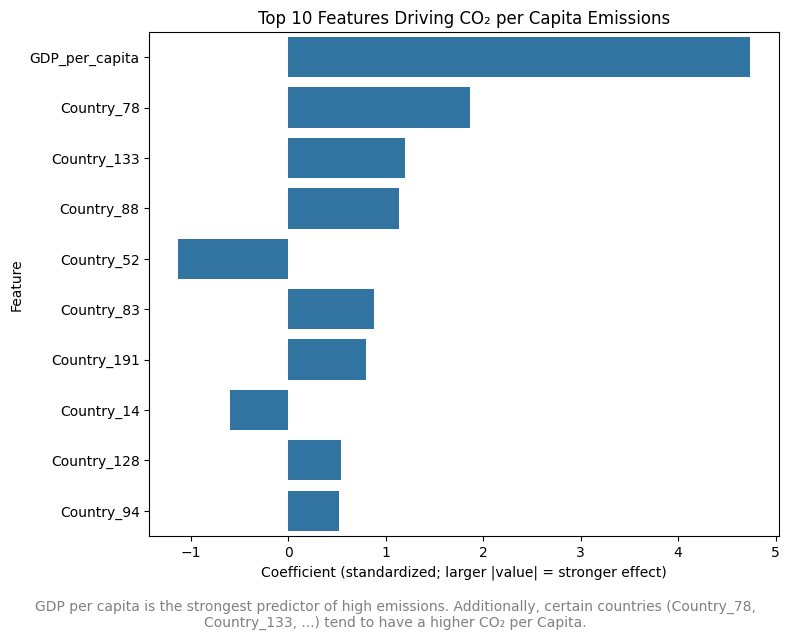

In [18]:
# Feature Importance: Top 10 drivers of CO₂ per capita

coef_series = pd.Series(best_model.coef_, index=cols)
top10 = coef_series.reindex(coef_series.abs().sort_values(ascending=False).head(10).index)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=top10.values, y=top10.index, orient="h", ax=ax)

ax.set_xlabel("Coefficient (standardized; larger |value| = stronger effect)")
ax.set_ylabel("Feature")
ax.set_title("Top 10 Features Driving CO₂ per Capita Emissions")
fig.tight_layout()

caption_text = "GDP per capita is the strongest predictor of high emissions. Additionally, certain countries (Country_78, Country_133, ...) tend to have a higher CO₂ per Capita."
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')

fig.savefig("fig_top10_feature_importance_co2.png", dpi=300, bbox_inches="tight")
plt.show()



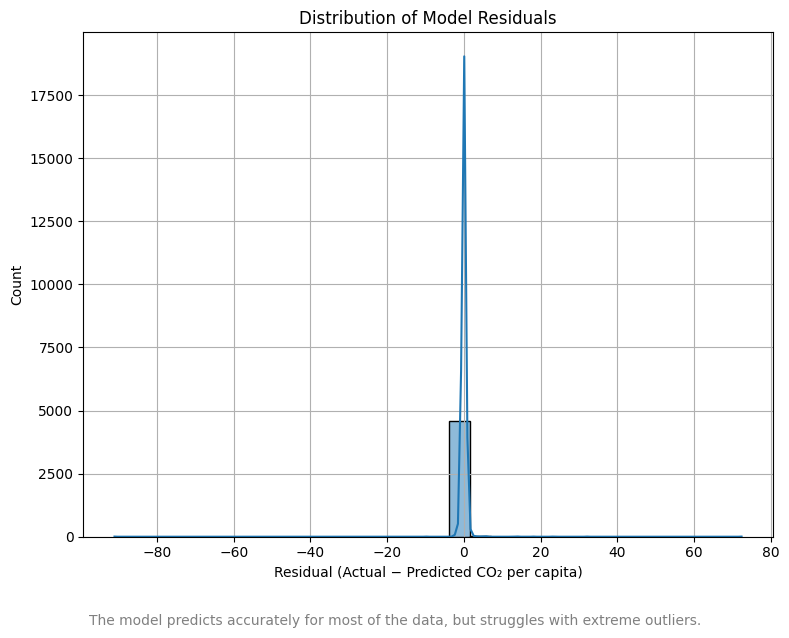

In [19]:
# Distribution of residuals (how the model is wrong)

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (Actual − Predicted CO₂ per capita)")
plt.ylabel("Count")
plt.title("Distribution of Model Residuals")
plt.grid(True)
plt.tight_layout()
caption_text = "The model predicts accurately for most of the data, but struggles with extreme outliers."
plt.figtext(0.5, -0.05, caption_text, wrap=True, ha='center', fontsize=10, color='gray')
plt.show()
